# AchromatCFW demo

This notebook demonstrates basic usage of the core functions in `scr.chromf.cfw`.

In [1]:
# ───────────────────────────── Imports ─────────────────────────────
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, Checkbox

# Allow “import chromf …” without installing the package
sys.path.insert(0, str(Path("..").resolve() / "src"))

from chromf.spectrum_loader import _load_defocus, channel_products
from chromf.cfw import (
    edge_rgb_response,
    detect_fringe_binary,
    fringe_width,
)

In [2]:
# ──────────────────────────── Constants ────────────────────────────
FN_DEFAULT       = 1.4        # f-number used in all cfw calls
GAMMA_DEFAULT    = 2.2        # display gamma
EXPOSURE_DEFAULT = 8.0    # tanh-curve slope (a.k.a. exposure factor)
XRANGE           = 400        # half-width of x-scan window (µm)
DEFOCUS_RANGE    = 600        # ±z sweep (µm)
DEFOCUS_STEP     = 10         # slider step (µm)

X_RES_P1   = 5               # Plot 1 sampling step (µm)
X_RES_P2   = 1               # Plot 2 sampling step (µm)
IMG_HEIGHT = 60              # Plot 2 image height (px)

# ──────────────────────────── Data load ────────────────────────────
focal_shift_curve = _load_defocus()          # [λ, defocus] table
wl      = focal_shift_curve[:, 0]
chl_um  = focal_shift_curve[:, 1]            # CHL(zf85) in µm

prods = channel_products()
sensor_map = {"R": prods["red"][:, 1],
              "G": prods["green"][:, 1],
              "B": prods["blue"][:, 1]}

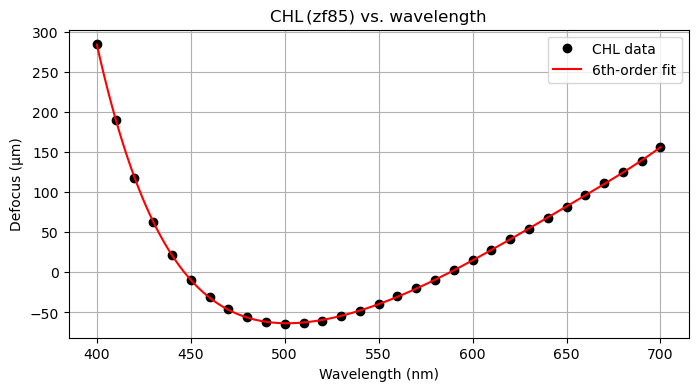

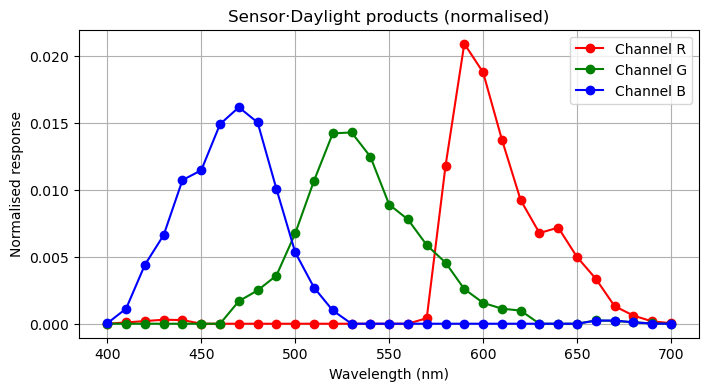

In [3]:
# ───────────────────── Optional diagnostic plots ───────────────────
# --- 1. CHL data and 6th-order fit ---------------------------------
coeffs = np.polyfit(wl, chl_um, 6)
wl_fit = np.linspace(wl.min(), wl.max(), 300)
chl_fit = np.polyval(coeffs, wl_fit)

plt.figure(figsize=(8, 4))
plt.plot(wl,      chl_um,  "o", color="k",   label="CHL data")
plt.plot(wl_fit,  chl_fit, "-", color="red", label="6th-order fit")
plt.title("CHL (zf85) vs. wavelength")
plt.xlabel("Wavelength (nm)");  plt.ylabel("Defocus (µm)")
plt.grid(True);  plt.legend();  plt.show()

# --- 2. Energy-normalised sensor curves ----------------------------
plt.figure(figsize=(8, 4))
for ch, col in {"R": "r", "G": "g", "B": "b"}.items():
    plt.plot(wl, sensor_map[ch], "o-", color=col, label=f"Channel {ch}")
plt.title("Sensor·Daylight products (normalised)");  plt.grid(True)
plt.xlabel("Wavelength (nm)");  plt.ylabel("Normalised response")
plt.legend();  plt.show()

In [ ]:
# ─────────────────────── Interactive section ───────────────────────
def update_plots(
    z: float,
    f_number: float,
    gamma: float,
    exposure: float,
    gaussian_psf: bool,
) -> None:
    psf_mode = "gauss" if gaussian_psf else "geom"

    # ---------- Plot 1: edge functions ----------
    x_vals = np.arange(-XRANGE, XRANGE + X_RES_P1, X_RES_P1, dtype=float)
    edge_rgb = np.array([
        edge_rgb_response(
            x, z,
            exposure_slope=exposure,
            gamma=gamma,
            chl_curve_um=chl_um,
            f_number=f_number,
            psf_mode=psf_mode,
        )
        for x in x_vals
    ])
    edge_r, edge_g, edge_b = edge_rgb.T

    boundaries = np.array([
        detect_fringe_binary(
            x, z,
            exposure_slope=exposure,
            gamma=gamma,
            chl_curve_um=chl_um,
            f_number=f_number,
            psf_mode=psf_mode,
        )
        for x in x_vals
    ], dtype=bool)

    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(x_vals, edge_r, color="r", label="R")
    ax1.plot(x_vals, edge_g, color="g", label="G")
    ax1.plot(x_vals, edge_b, color="b", label="B")

    jumps = np.flatnonzero(np.diff(boundaries.astype(int), prepend=boundaries[0]))
    for idx in jumps:
        ax1.axvline(x_vals[idx], color="k", ls="--", lw=1,
                    label="Fringe boundary" if idx == jumps[0] else None)

    ax1.set(xlabel="x (µm)", ylabel="Normalised response",
            title=f"Edge responses — {'Gaussian' if gaussian_psf else 'Geometric'} PSF",
            ylim=(0, 1))
    ax1.legend();  ax1.grid(True)

    # ---------- Plot 2: pseudo-density map ----------
    X = np.arange(-XRANGE, XRANGE + X_RES_P2, X_RES_P2, dtype=float)
    img_row = np.array([
        edge_rgb_response(
            x, z,
            exposure_slope=exposure,
            gamma=gamma,
            chl_curve_um=chl_um,
            f_number=f_number,
            psf_mode=psf_mode,
        )
        for x in X
    ])
    img = np.repeat(np.clip(img_row, 0, 1)[:, None, :], IMG_HEIGHT, axis=1)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(img.swapaxes(0, 1),
               extent=[X.min(), X.max(), 0, IMG_HEIGHT],
               aspect="auto", origin="lower")
    ax2.set_xlabel("x (µm)");  ax2.set_yticks([])
    ax2.set_title("Pseudo-density fringe map")

    plt.tight_layout();  plt.show()

    width = fringe_width(
        z,
        exposure_slope=exposure,
        gamma=gamma,
        chl_curve_um=chl_um,
        f_number=f_number,
        psf_mode=psf_mode,
    )
    print(f"Colour-fringe width ≈ {width} µm")

# ipywidgets driver -- note all sliders use keyword args only
interact(
    update_plots,
    z=FloatSlider(
        value=0, min=-DEFOCUS_RANGE, max=DEFOCUS_RANGE, step=DEFOCUS_STEP,
        description="Defocus (µm)", continuous_update=False),
    f_number=FloatSlider(
        value=FN_DEFAULT, min=1.0, max=4.0, step=0.1,   # default now 1.4
        description="f-number", continuous_update=False),
    gamma=FloatSlider(
        value=GAMMA_DEFAULT, min=1.0, max=3.0, step=0.1, # default now 2.2
        description="Gamma", continuous_update=False),
    exposure=FloatSlider(
        value=EXPOSURE_DEFAULT, min=1, max=16, step=1,
        description="Exposure", continuous_update=False),
    gaussian_psf=Checkbox(value=True, description="Gaussian PSF"),
)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Defocus (µm)', max=600.0, m…

<function __main__.update_plots(z: float, f_number: float, gamma: float, exposure: float, gaussian_psf: bool) -> None>

In [7]:
# ---------------------------------------------------------------------
# Defocus vector (z samples, µm)
# ---------------------------------------------------------------------
z_vals = np.arange(-DEFOCUS_RANGE, DEFOCUS_RANGE + DEFOCUS_STEP,
                   DEFOCUS_STEP, dtype=float)

# ---------------------------------------------------------------------
# Single-curve helper
# ---------------------------------------------------------------------
def _plot_cfw_curve(exposure: float, psf_mode: str, label: str) -> np.ndarray:
    """Compute CFW for every z, draw the curve, and return [z, CFW] samples."""
    data = np.array([
        [
            z,
            fringe_width(
                z,
                exposure_slope=exposure,
                gamma=GAMMA_DEFAULT,
                chl_curve_um=chl_um,
                f_number=FN_DEFAULT,        # ← global constant
                psf_mode=psf_mode,
            ),
        ]
        for z in z_vals
    ])
    plt.plot(data[:, 0], data[:, 1], "o-", ms=3, label=label)
    return data

# ---------------------------------------------------------------------
# Comparison plot + statistics
# ---------------------------------------------------------------------
def plot_cfw_comparison(
    exposures=(EXPOSURE_DEFAULT,),
    gaussian_psf: bool = True,
) -> None:
    """Draw a CFW-vs-z curve for each exposure value and print basic stats."""
    psf_mode  = "gauss" if gaussian_psf else "geom"
    psf_label = "Gaussian PSF" if gaussian_psf else "Geometric PSF"

    plt.figure(figsize=(8, 4))
    print(f"\n=== Statistics ({psf_label}, f-number={FN_DEFAULT}) ===")
    print("Exp  max(width)   mean(width)")
    print("-" * 30)

    for exp in sorted(exposures):
        data = _plot_cfw_curve(exp, psf_mode, label=f"Exposure = {exp}")
        print(f"{exp:<4} {data[:,1].max():>10.2f}   {data[:,1].mean():>10.2f}")

    plt.title(f"Colour-fringe width vs defocus — {psf_label}")
    plt.xlabel("Defocus z (µm)")
    plt.ylabel("Colour-fringe width (µm)")
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------------------------------------------------------------
# ipywidgets driver
# ---------------------------------------------------------------------
def interactive_plot(exposures, gaussian_psf):
    plot_cfw_comparison(exposures=exposures, gaussian_psf=gaussian_psf)

exposures_widget = widgets.SelectMultiple(
    options=[1, 2, 4, 6, 8, 10, 12, 16],
    value=[1, 2, 4, 8],
    description="Exposure",
)

gaussian_widget = Checkbox(
    value=True,
    description="Gaussian PSF",
)

interact(
    interactive_plot,
    exposures=exposures_widget,
    gaussian_psf=gaussian_widget,
)


interactive(children=(SelectMultiple(description='Exposure', index=(0, 1, 2, 4), options=(1, 2, 4, 6, 8, 10, 1…

<function __main__.interactive_plot(exposures, gaussian_psf)>